## Future Sales Forecast

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

#### Load Datasets

In [2]:
items = pd.read_csv('datasets/items.csv')
shops = pd.read_csv('datasets/shops.csv')
sales = pd.read_csv('datasets/sales_train.csv')
items_categories = pd.read_csv('datasets/item_categories.csv')

### Data Processing

In [3]:
# Converting the column 'date' to type 'datetime'.
sales['date'] = sales['date'].apply(lambda d: pd.datetime.strptime(d, '%d.%m.%Y'))

In [4]:
# Create columns 'month' and 'total'.
sales['month'] = sales['date'].apply(lambda s: s.month)
sales['total_value'] = sales['item_price'] * sales['item_cnt_day']

In [9]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,total_value
0,2013-01-02,0,59,22154,999.00,1.0,1,999.00
1,2013-01-03,0,25,2552,899.00,1.0,1,899.00
2,2013-01-05,0,25,2552,899.00,-1.0,1,-899.00
3,2013-01-06,0,25,2554,1709.05,1.0,1,1709.05
4,2013-01-15,0,25,2555,1099.00,1.0,1,1099.00


### Data Analysis and Exploration

In [6]:
sales_per_month_2013 = sales[sales['date'] < '2014-01-01']
sales_per_month_2013 = sales_per_month_2013.groupby(['month'])['item_cnt_day', 'total_value'].sum()

sales_per_month_2014 = sales[(sales['date'] > '2013-12-31') & (sales['date'] < '2015-01-01')]
sales_per_month_2014 = sales_per_month_2014.groupby(['month'])['item_cnt_day', 'total_value'].sum()

sales_per_month_2015 = sales[sales['date'] > '2014-12-31']
sales_per_month_2015 = sales_per_month_2015.groupby(['month'])['item_cnt_day', 'total_value'].sum()

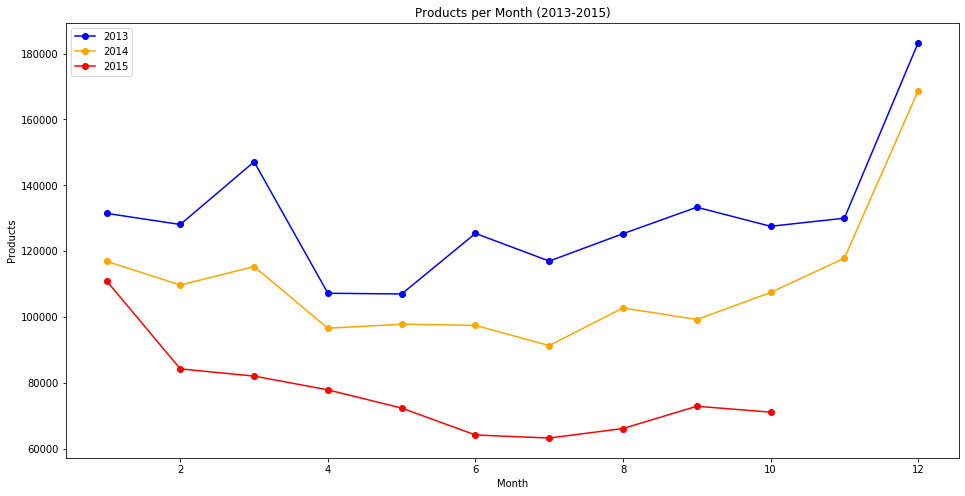

In [100]:
plt.figure(figsize=(16,8))
plt.xlabel('Month')
plt.ylabel('Products')
plt.title('Products per Month (2013-2015)')
plt.plot(sales_per_month_2013['item_cnt_day'], '-ok', color='blue', label='2013')
plt.plot(sales_per_month_2014['item_cnt_day'], '-ok', color='orange', label='2014')
plt.plot(sales_per_month_2015['item_cnt_day'], '-ok', color='red', label='2015')
plt.legend()

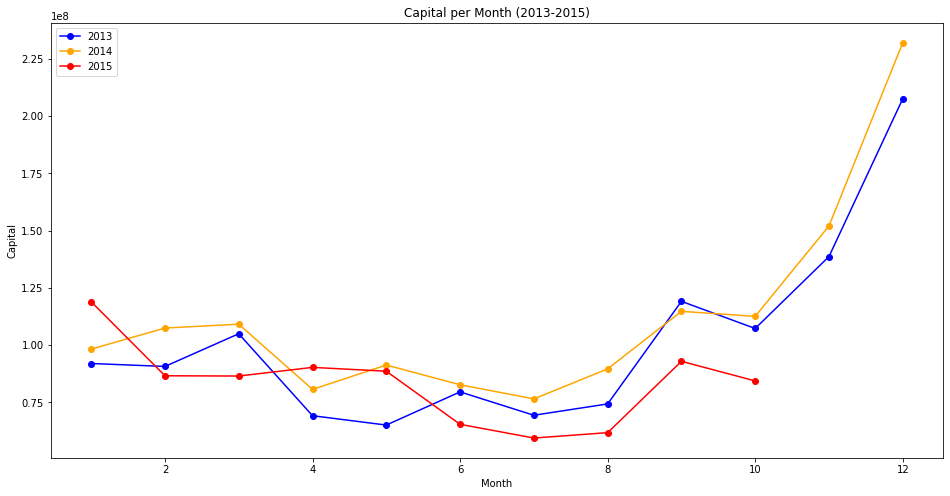

In [99]:
plt.figure(figsize=(16,8))
plt.xlabel('Month')
plt.ylabel('Capital')
plt.title('Capital per Month (2013-2015)')
plt.plot(sales_per_month_2013['total_value'], '-ok', color='blue', label='2013')
plt.plot(sales_per_month_2014['total_value'], '-ok', color='orange', label='2014')
plt.plot(sales_per_month_2015['total_value'], '-ok', color='red', label='2015')
plt.legend()

In [60]:
total_sales = sales.groupby(['date_block_num'])['item_cnt_day'].sum()

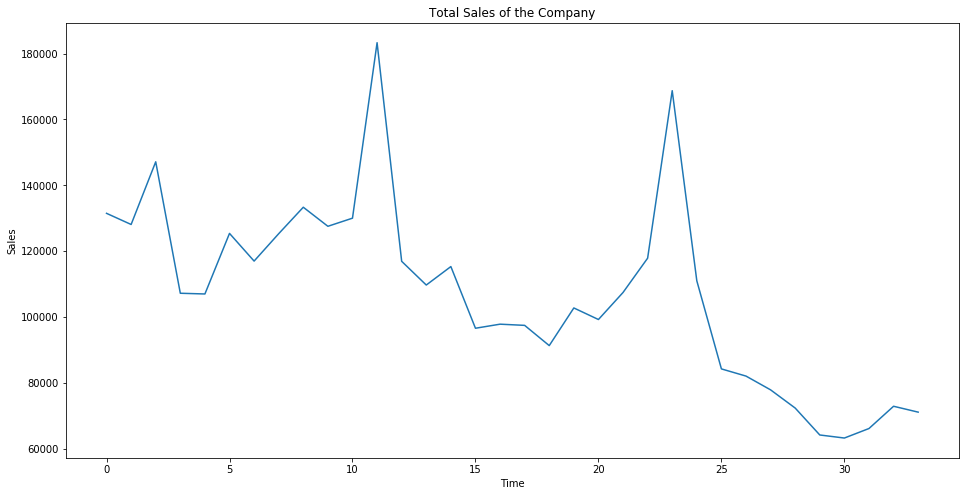

In [98]:
plt.figure(figsize=(16,8))
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Total Sales of the Company')
plt.plot(total_sales)

In [56]:
decomposition = seasonal_decompose(total_sales.values, freq=12)

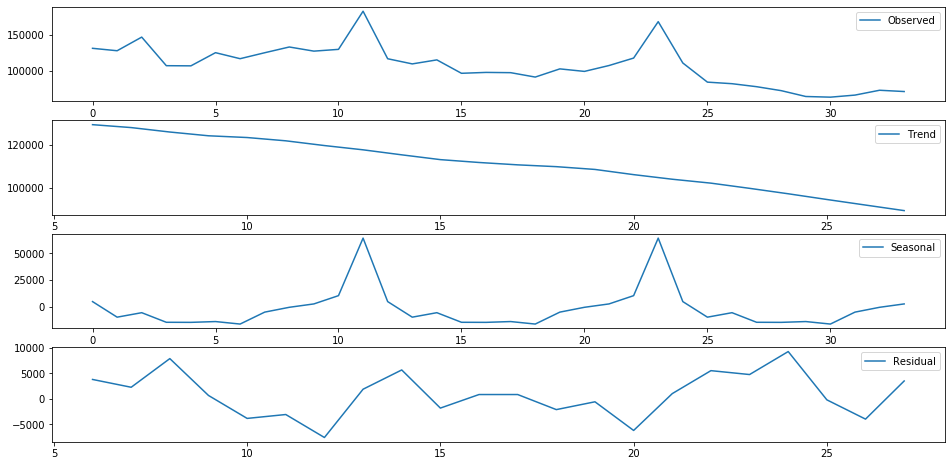

In [97]:
plt.figure(figsize=(16,8))

plt.subplot(4, 1, 1)
plt.plot(total_sales, label='Observed')
plt.legend(loc='best')

plt.subplot(4, 1, 2) 
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='best')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='best')